In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Path to your dataset of cricketers' images
dataset_path = '/content/drive/MyDrive/Ashutosh/FanPlay/Cricket Legends'

# Image dimensions and channels
img_width, img_height, channels = 64, 64, 3



In [ ]:
# Generator model
def build_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(img_width * img_height * channels, activation='tanh'))
    model.add(layers.Reshape((img_width, img_height, channels)))
    return model

# Discriminator model
def build_discriminator(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Combine generator and discriminator into a cGAN model
def build_cgan(generator, discriminator):
    latent_dim = generator.input_shape[1]
    noise = layers.Input(shape=(latent_dim,))
    img = generator(noise)
    discriminator.trainable = False
    validity = discriminator(img)
    model = tf.keras.Model(noise, validity)
    return model

# Compile discriminator
img_shape = (img_width, img_height, channels)
discriminator = build_discriminator(img_shape)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile cGAN
latent_dim = 100
generator = build_generator(latent_dim)
cgan = build_cgan(generator, discriminator)
cgan.compile(optimizer='adam', loss='binary_crossentropy')

# Training parameters
epochs = 10000
batch_size = 64

# Use ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator for the cricketers' dataset
cricketers_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 6729 images belonging to 1 classes.


2/2 [==============================] - 0s 30ms/step
Epoch 0, D Loss: 0.6706180572509766, G Loss: 0.36620819568634033
1/1 [==============================] - 0s 145ms/step


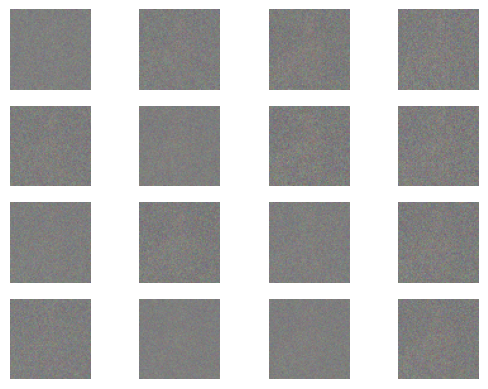

2/2 [==============================] - 0s 32ms/step


In [ ]:
# Training loop
for epoch in range(epochs):
    # Train discriminator
    real_images, labels_real = cricketers_generator.next()
    real_images = (real_images - 0.5) / 0.5  # Rescale pixel values to [-1, 1]
    labels_real = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_images = generator.predict(noise)
    labels_fake = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(fake_images, labels_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    labels_gan = np.ones((batch_size, 1))
    g_loss = cgan.train_on_batch(noise, labels_gan)

    # Print progress and save generated images at intervals
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        # Save generated images
        samples = generator.predict(np.random.normal(0, 1, (16, latent_dim)))
        samples = (samples + 1) / 2.0  # Rescale pixel values to [0, 1]
        fig, axs = plt.subplots(4, 4)
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(samples[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        plt.show()
